In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from globalbiopak.EMutils import *
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


cuda:3
torch.Size([292, 292, 292])


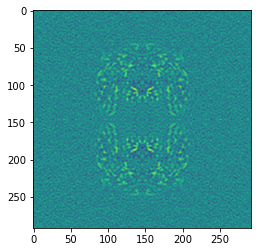

In [44]:
import gemmi
ccp4_map = gemmi.read_ccp4_map('../data/betagal2984.map')
data = torch.Tensor(np.array(ccp4_map.grid)).to(device)
print(data.device)
print(data.shape)
plt.imshow(data.cpu()[146, :, :])

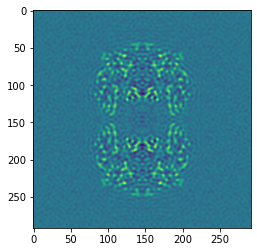

In [45]:
data = torch.Tensor(np.array(ccp4_map.grid)).to(device)
size = data.shape[0]
radius = int(size / 5)
center = int(size / 2)
x = np.linspace(0, size, size, dtype=np.uint)
xx,yy,zz = np.meshgrid(x, x, x)
mask = ((xx-center)**2 + (yy-center)**2 + (zz-center)**2) > radius**2

fdata = torch.fft.fftshift(torch.fft.fftn(data))
fdata[mask] = 0
data = torch.real(torch.fft.ifftn(torch.fft.ifftshift(fdata)))
plt.imshow(torch.log(torch.abs(fdata)).cpu()[146, :, :])
plt.imshow(data.cpu()[146, :, :])

downsampling_ratio = 2
data = data[::downsampling_ratio, ::downsampling_ratio, ::downsampling_ratio]

In [46]:
snr_low = -50
snr_high = 20
snr_points = 10
SNRs = np.linspace(snr_low, snr_high, snr_points)
errs_real = np.zeros(snr_points)

angle_scale = 0.1
for idx, SNR in tqdm(enumerate(SNRs)):
    proj_meas, proj_anglesrot, proj_anglesazi, proj_anglessph = generate_random_proj(
        data, num_proj=400, angle_scale=angle_scale, SNR=SNR)
    template_proj, templanglesrot, templanglesazi, templanglessph = generate_template_proj(
        data, Nsampl=10, angle_scale=angle_scale)
    max_idx = template_matching(proj_meas, template_proj)
    errs_real[idx] = compute_matching_error(proj_anglesrot, proj_anglessph, proj_anglesazi, 
        templanglesrot, templanglessph, templanglesazi, max_idx)

0it [00:00, ?it/s]/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/tomosipo/links/torch.py:63: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  warnings.warn(
10it [00:04,  2.47it/s]


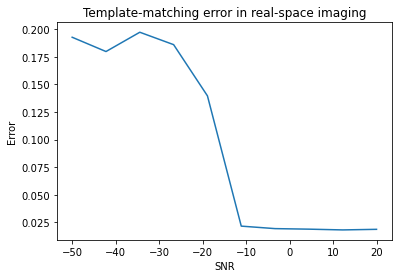

In [47]:
plt.plot(SNRs, errs_real)
plt.xlabel('SNR')
plt.ylabel('Error')
plt.title('Template-matching error in real-space imaging');

In [52]:
snr_low = -50
snr_high = 500
snr_points = 10
SNRs = np.linspace(snr_low, snr_high, snr_points)
errs_fourier = np.zeros(snr_points)

angle_scale = 0.1
for idx, SNR in tqdm(enumerate(SNRs)):
    proj_meas, proj_anglesrot, proj_anglesazi, proj_anglessph = generate_random_proj_fourier(
        data, num_proj=400, angle_scale=angle_scale, SNR=SNR)
    template_proj, templanglesrot, templanglesazi, templanglessph = generate_template_proj_fourier(
        data, Nsampl=10, angle_scale=angle_scale)
    preproc = lambda x: x**0.5
    max_idx = template_matching(proj_meas, template_proj, preproc=preproc)
    errs_fourier[idx] = compute_matching_error(proj_anglesrot, proj_anglessph, proj_anglesazi, 
        templanglesrot, templanglessph, templanglesazi, max_idx)

0it [00:00, ?it/s]/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/tomosipo/links/torch.py:63: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  warnings.warn(
10it [00:03,  2.52it/s]


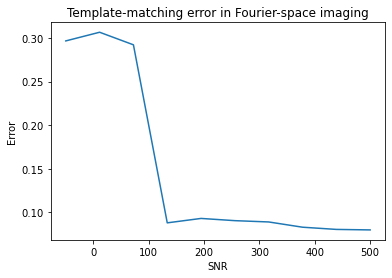

In [53]:
plt.plot(SNRs, errs_fourier)
plt.xlabel('SNR')
plt.ylabel('Error')
plt.title('Template-matching error in Fourier-space imaging');